In [1]:
import numpy as np # Numpy is a popular numeric computation package
import pandas as pd # Pandas is a friendly data wrangling package/library
from scipy import linalg
import matplotlib.pyplot as pl
from GPR import GPR
# Setting a specific random seed, to get reproducibility across students.
# @Students, you can remove or change to your own seed to try with your own training subsets.
np.random.seed(100) 
# Plotting
import plotly.express as px
import plotly.graph_objects as go
# Reproducibility
import watermark

In [2]:
adt = pd.read_csv("../Warping-tests/engineered_data/assay_desurveyed_transformed_Mlith_domain.csv")
domained = pd.read_csv('../Warping-tests/engineered_data/blockmodel_domained_NN.csv')

In [3]:
# subset assay data by domains
adt_FLT_HBX_HWS = adt[adt["MLITHGROUPINGS2"] == "INTR"]
adt_FLT_HBX_HWS_Cu = adt_FLT_HBX_HWS.loc[:,["HOLEID", 'EAST_mid_tf', 'NORTH_mid_tf', 'RL_mid_tf', 'Cu_pct']]

# NaN values causing trouble
#adt_FLT_HBX_HWS_Cu["Cu_pct"] = adt_FLT_HBX_HWS_Cu["Cu_pct"].fillna(0)
print(adt_FLT_HBX_HWS_Cu["Cu_pct"].isna().sum())
adt_FLT_HBX_HWS_Cu

0


,HOLEID,EAST_mid_tf,NORTH_mid_tf,RL_mid_tf,Cu_pct
1717,OTD1425,-489.699937,93.725340,1747.734096,0.00000
3310,OTD1769,445.987252,1190.506493,277.690835,0.01285
3311,OTD1769,446.779556,1190.589769,275.856367,0.22400
4587,OTD1772,-367.617547,98.543817,1717.673993,0.06670
4588,OTD1772,-367.981943,98.529202,1715.707525,0.01400
...,...,...,...,...,...
42351,OTRC2402,171.934690,110.366182,1612.646600,0.00000
42352,OTRC2402,171.287201,110.909489,1610.833984,0.00000
42356,OTRC2402,168.697246,113.082719,1603.583522,0.00000
42358,OTRC2402,167.402269,114.169335,1599.958291,0.00000


In [4]:
adt_FLT_HBX_HWS_Cu = adt_FLT_HBX_HWS_Cu.dropna(subset=['Cu_pct'])

In [5]:
x = adt_FLT_HBX_HWS_Cu[['EAST_mid_tf','NORTH_mid_tf', 'RL_mid_tf']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = adt_FLT_HBX_HWS_Cu['Cu_pct'].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(adt_FLT_HBX_HWS_Cu),3)

print(f"x has shape ({x.shape[0]},{x.shape[1]}) and has range [{np.min(x):.3f},{np.max(x):.3f}]")
print(f"y has shape ({y.shape[0]},{y.shape[1]}) and has range [{np.min(y):.3f},{np.max(y):.3f}]")

x has shape (230,3) and has range [-489.700,1747.734]
y has shape (230,1) and has range [0.000,1.055]


In [6]:
def calc_moving_avg(dataframe, variable_name_str, window_size = 5, ):
    index_var = int(np.where(adt_FLT_HBX_HWS_Cu.columns == "Cu_pct")[0])
    i = 0
    # List fo all holeids
    holeid_list = np.unique(dataframe["HOLEID"]).reshape(-1)
    # empty container
    moving_avg_list = []
    # Iterate over all holes
    for i in range(holeid_list.shape[0]):
        # Retrieve name of holeid
        holeid = holeid_list[i]
        # Create subset
        dataframe_holeid_subset = dataframe[dataframe["HOLEID"] == holeid]
        # Iterate over all rows in subset
        subset_length = dataframe_holeid_subset.shape[0]
        j = 0
        # end not included
        for j in range(subset_length):
            if (j < ((window_size - 1)/2)):
                ma = np.mean(dataframe_holeid_subset.iloc[0:int(j + ((window_size - 1)/2) + 1), index_var])
                moving_avg_list.append(ma)
                j = j + 1
            elif (j > (subset_length - ((window_size - 1)/2) - 2)):
                ma = np.mean(dataframe_holeid_subset.iloc[j:subset_length, index_var])
                moving_avg_list.append(ma)
                j = j + 1
            else:
                ma = np.mean(dataframe_holeid_subset.iloc[(j-2):(j+3), index_var])
                moving_avg_list.append(ma)
                j = j + 1
        i = i + 1
    return(moving_avg_list)

In [7]:
#moving_average_list = calc_moving_avg(window_size = 5, dataframe = adt_FLT_HBX_HWS_Cu, variable_name_str = "Cu_pct")

#adt_FLT_HBX_HWS_Cu["moving_average_Cu_pct"] = moving_average_list

In [8]:
holeid_list = np.unique(adt_FLT_HBX_HWS_Cu["HOLEID"]).reshape(-1)
# 150 holdeids for training
# 65 holeids for val
int(holeid_list.shape[0] * 0.7)

np.random.seed(42)

train_index_list = np.random.choice(holeid_list.shape[0], size = int(holeid_list.shape[0] * 0.7), replace = False)
val_index_list = list(set(range(holeid_list.shape[0])).difference(train_index_list))

holeid_list[train_index_list]
holeid_list[val_index_list]

train_subset = adt_FLT_HBX_HWS_Cu[adt_FLT_HBX_HWS_Cu["HOLEID"].isin(holeid_list[train_index_list])]
val_subset = adt_FLT_HBX_HWS_Cu[adt_FLT_HBX_HWS_Cu["HOLEID"].isin(holeid_list[val_index_list])]

In [9]:
# training data: torch.tensor format. Division my 1000 to have input and output dimensions similar
train_x = np.array(train_subset.loc[:,['EAST_mid_tf', 'NORTH_mid_tf', 'RL_mid_tf']])
# y expected to be scalar
#train_y = np.array(train_subset.loc[:,['bc_ma_Cu_pct']])
train_y = np.array(train_subset.loc[:,['Cu_pct']])*100

# Validation data: torch.tensor format 
val_x = np.array(val_subset.loc[:,['EAST_mid_tf', 'NORTH_mid_tf', 'RL_mid_tf']])
# y expected to be scalar
#val_y = np.array(val_subset.loc[:,['bc_ma_Cu_pct']])
val_y = np.array(val_subset.loc[:,['Cu_pct']])*100

# MA: moving average (not transformed)

print(train_x.shape)
print(train_y.shape)

(118, 3)
(118, 1)


In [10]:
def transform_to_tanh(y, a, b, c):
    """
    Transforms a given variable to its hyperbolic tangent as a weighted sum.

    Args:
        t: A scalar or tensor to be transformed.
        a: A 1D numpy array of length I containing the weights for each element in the sum.
        b: A 1D numpy array of length I containing the scaling factors for each element in the sum.
        c: A 1D numpy array of length I containing the offsets for each element in the sum.

    Returns:
        The hyperbolic tangent of y.
    """
    # Compute the weighted sum of hyperbolic tangents
    f = np.sum(a * np.tanh(b * (y + c)))
    
    return f

In [11]:
def derivative_tanh(y, a, b, c):
    """
    Computes the derivative of a given function with respect to t.

    Args:
        t: A scalar or tensor with respect to which to take the derivative.
        a: A 1D numpy array of length I containing the weights for each element in f.
        b: A 1D numpy array of length I containing the scaling factors for each element in f.
        c: A 1D numpy array of length I containing the offsets for each element in f.

    Returns:
        The derivative of f with respect to t.
    """
    # Compute the derivative of f with respect to t using the chain rule
    df_dy = np.sum(a * b * (1 - np.tanh(b * (y + c)) ** 2))
    
    return df_dy

In [12]:
signal_variance = 0.15 #1
lengthscale = 50000 #0.3
sigma_n = 0.1 #0.1
gp = GPR("Squared Exponential", train_x, train_y, [signal_variance,lengthscale], sigma_n)
[f_mean_2,f_std_2] = gp.predict(val_x)
lml = gp.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))
print(np.mean(f_mean_2), np.mean(val_y))
print(np.max(f_mean_2), np.max(val_y))


Log Marginal Likelihood: [[-385346.74344234]]
7.133386126403201 4.698083928571429
9.745265385243934 105.5


In [13]:
from scipy.optimize import minimize

def eval_params(params, gp):
    params = np.exp(params)
    gp.set_hyper_params(params[:-1],params[len(params)-1])
    nlml = -gp.log_marginal_likelihood()
    print(str(params)+str(nlml))
    return nlml

x0 = np.array([np.log(0.15), np.log(50000), np.log(0.1)])
res = minimize(eval_params, x0, method='nelder-mead', args=(gp),
               options={'xatol': 1e-10, 'disp': True})
print(res)

[1.5e-01 5.0e+04 1.0e-01][[385346.74344236]]
[1.36425584e-01 5.00000000e+04 1.00000000e-01][[386430.9473872]]
[1.50000000e-01 8.58852343e+04 1.00000000e-01][[396616.28025736]]
[1.50000000e-01 5.00000000e+04 8.91250938e-02][[482012.84525001]]
[1.40808099e-01 7.17137343e+04 1.12201845e-01][[314721.34058216]]
[1.36425584e-01 8.58852343e+04 1.25892541e-01][[255367.07484128]]
[1.32179471e-01 4.17497460e+04 1.16591440e-01][[285058.42471834]]
[1.42300002e-01 6.35904005e+04 1.29154967e-01][[238182.09736377]]
[1.45331396e-01 7.17137343e+04 1.46779927e-01][[187422.77539107]]
[1.26722849e-01 8.08747806e+04 1.66810054e-01][[148483.21459931]]
[1.16476084e-01 1.02857194e+05 2.15443469e-01][[92065.37180614]]
[1.32179471e-01 1.76678284e+05 2.15443469e-01][[93281.69159474]]
[1.25394260e-01 1.38918990e+05 2.85466766e-01][[53722.73989074]]
[1.20217744e-01 1.76678284e+05 4.29866235e-01][[24517.97460238]]
[1.03725797e-01 3.03481116e+05 5.01187234e-01][[18582.32035902]]
[8.76295233e-02 6.24304318e+05 9.2611

c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


[3.54001549e-02 1.70291405e+07 3.50303474e+01][[inf]]
[5.32723127e-02 1.26930615e+07 1.65864363e+01][[460.55753024]]
[3.78290134e-02 4.32822361e+07 1.10670768e+02][[inf]]
[7.10303722e-02 1.80146022e+06 3.06202146e+00][[809.79284702]]
[4.66693093e-02 1.49996578e+07 3.34727472e+01][[inf]]
[6.39500534e-02 3.06012274e+06 5.56774084e+00][[490.33711523]]
[5.18363666e-02 8.83013175e+06 1.84085922e+01][[468.97134907]]
[5.46306216e-02 6.77501247e+06 1.36516513e+01][[447.39367218]]
[6.32795876e-02 1.40077631e+06 5.42710097e+00][[496.74500243]]
[5.56150169e-02 7.31588693e+06 1.25445992e+01][[443.00477191]]
[6.24452876e-02 2.76225010e+06 6.23232662e+00][[468.21520673]]
[5.64874571e-02 5.41375158e+06 1.12215136e+01][[438.80637986]]
[4.50684577e-02 9.35286276e+06 1.40730491e+01][[449.20726784]]
[6.09020882e-02 3.96587004e+06 8.99008333e+00][[437.48470019]]
[5.79685862e-02 2.53237698e+06 6.95597886e+00][[453.39811443]]
[5.61942957e-02 5.61154342e+06 1.08251060e+01][[437.90009405]]
[6.28335110e-02 6.5

In [14]:
optimal_params = np.exp(res.x)

print("Optimal signal variance: "+str(optimal_params[0]))
print("Optimal lengthscale: "+str(optimal_params[1]))
print("Optimal noise std: "+str(optimal_params[2]))

gp.set_hyper_params([optimal_params[0],optimal_params[1]],optimal_params[2])

#Predict for x_star
[f_mean,f_std] = gp.predict(val_x)
lml = gp.log_marginal_likelihood()

print("Log Marginal Likelihood: "+str(lml))



Optimal signal variance: 33.22284862524504
Optimal lengthscale: 5131.6924483461
Optimal noise std: 8.409719147469717
Log Marginal Likelihood: [[-426.98048509]]


In [29]:
I = 1
val_a = 2
val_b = 1
val_c = 0
a = np.full(I, val_a)
b = np.full(I, val_b)
c = np.full(I, val_c)

nuv = 1/2

signal_variance = 2000000 #1
lengthscale = 300 #0.3
sigma_n = 0.1 #0.1
gpw = GPR("Matern", train_x, train_y, [signal_variance,lengthscale], sigma_n, [a,b,c], 5/2)
[fw_mean_2,fw_std_2] = gpw.predict(val_x)
lml = gpw.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))
print(np.max(fw_mean_2), np.max(val_y))


fw_norm_train = 0
fw_norm_test = 0
for i in range(I):
    fw_norm_train += a[i]* np.tanh(b[i] * (train_y + c[i])) 
    fw_norm_test += a[i] * np.tanh(b[i] * (val_y + c[i])) 

Log Marginal Likelihood: [[-inf]]
168.33538564675337 105.5


In [30]:
np.min(gpw.df_dy)

0.0

In [16]:
from scipy.optimize import minimize

def eval_params(params, gp):
    params = np.exp(params)
    a = np.array([params[2+3*i] for i in range(I)])
    b = np.array([params[3+3*i] for i in range(I)])
    c = np.array([params[4+3*i] for i in range(I)])
    gpw.set_hyper_params([params[:2], [a,b,c]], params[len(params)-1])
    nlml = -gpw.log_marginal_likelihood()
    print(str(params)+str(nlml))
    return nlml

#100, 0.05, 0.1, 0.1, 0.001, 0.3
x0 = np.array([np.log(2000), np.log(1000)] + [np.log(2), np.log(0.1), np.log(0.001)]*I + [np.log(0.9)])
res = minimize(eval_params, x0, method='powell', args=(gp),
               options={'xatol': 1e-10, 'disp': True})
print(res)

C:\Users\23478671\AppData\Local\Temp\ipykernel_9036\40440920.py:15: OptimizeWarning: Unknown solver options: xatol
  res = minimize(eval_params, x0, method='powell', args=(gp),


ValueError: operands could not be broadcast together with shapes (118,118) (3,1) 

In [ ]:
optimal_params = np.exp(res.x)

print("Optimal signal variance: "+str(optimal_params[0]))
print("Optimal lengthscale: "+str(optimal_params[1]))
print("Optimal noise std: "+str(optimal_params[-1]))
for i in range(I):
    print(f'Optimal a{i+1}:' +str(optimal_params[2+3*i]))
    print(f'Optimal b{i+1}:' +str(optimal_params[3+3*i]))
    print(f'Optimal c{i+1}:' +str(optimal_params[4+3*i]))  

a = np.array([optimal_params[2+3*i] for i in range(I)])
b = np.array([optimal_params[3+3*i] for i in range(I)])
c = np.array([optimal_params[4+3*i] for i in range(I)])

gpw.set_hyper_params([optimal_params[:2], [a,b,c]], optimal_params[len(optimal_params)-1])

#Predict for x_star
[fw_mean_2,fw_std_2] = gpw.predict(val_x)
lml = gpw.log_marginal_likelihood()
print("Log Marginal Likelihood: "+str(lml))


fw_norm_train = 0
fw_norm_test = 0

for i in range(I):
    fw_norm_train += optimal_params[3*i+2] * np.tanh(optimal_params[3*i+3] * (train_y + optimal_params[3*i+4])) 
    fw_norm_test += optimal_params[3*i+2] * np.tanh(optimal_params[3*i+3] * (val_y + optimal_params[3*i+4])) 



Optimal signal variance: 55.70385778723766
Optimal lengthscale: 672.6241642301383
Optimal noise std: 0.37465169356626676
Optimal a1:10.69027213135725
Optimal b1:0.13976387473380522
Optimal c1:8.797973006865005
Log Marginal Likelihood: [[-299.50444148]]


In [ ]:
[fw_mean_original, fw_std_original] = gpw.predict_original(val_x)

In [ ]:
mae = np.mean(np.abs(f_mean - val_y))
mae2 = np.mean(np.abs(fw_mean_original - val_y))

print("GP warp MAE:",mae2 )
print("GP MAE:",mae )

GP warp MAE: 7.519371024232543
GP MAE: 4.193546314837643


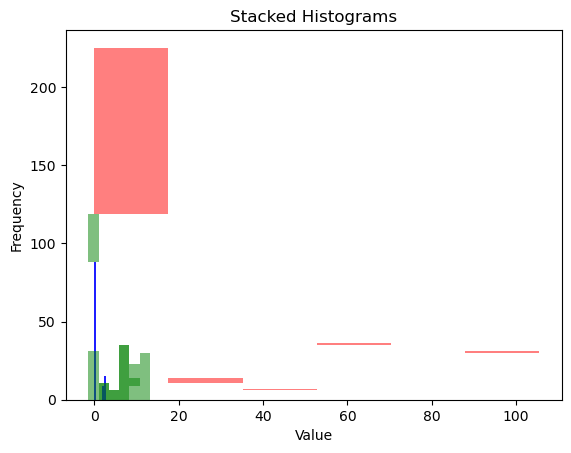

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data for the histograms
data1 = np.random.normal(0, 1, 1000)
data2 = np.random.normal(2, 1, 1000)
data3 = np.random.normal(-2, 1, 1000)

nbin = 6

# Create the first histogram plot
plt.hist(f_mean, bins=nbin, color='blue', alpha=0.5)

# Create the second histogram plot and stack it on top of the first plot
plt.hist(fw_mean_original, bins=nbin, color='green', alpha=0.5, bottom=plt.hist(f_mean, bins=nbin, color='blue', alpha=0.5)[0])

# Create the third histogram plot and stack it on top of the first two plots
plt.hist(val_y, bins=nbin, color='red', alpha=0.5, bottom=plt.hist(f_mean, bins=nbin, color='blue', alpha=0.5)[0] + plt.hist(fw_mean_original, bins=nbin, color='green', alpha=0.5)[0])

# Set the title and axis labels
plt.title("Stacked Histograms")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Display the histogram
plt.show()


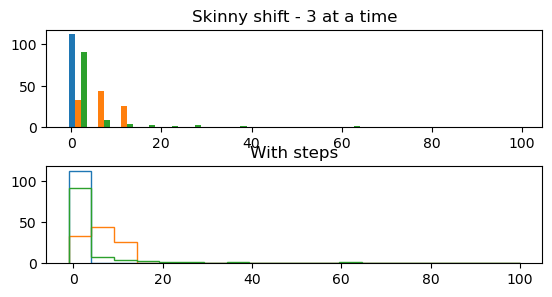

In [ ]:
a = np.array(f_mean).reshape(-1)
b = np.array(fw_mean_original).reshape(-1)
c = np.array(val_y).reshape(-1)

common_params = dict(bins=20, range=[-1, 100])

plt.subplots_adjust(hspace=.4)

plt.subplot(312)
plt.title('Skinny shift - 3 at a time')
plt.hist((a, b, c), **common_params)
plt.subplot(313)
common_params['histtype'] = 'step'
plt.title('With steps')
plt.hist(a, **common_params)
plt.hist(b, **common_params)
plt.hist(c, **common_params)

plt.savefig('3hist.png')
plt.show()

(array([[88., 24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [22., 11.,  2., 34.,  9., 10., 15.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [51., 32., 11.,  3.,  3.,  2.,  0.,  2.,  2.,  0.,  0.,  1.,  0.,
          1.,  1.,  0.,  0.,  0.,  0.,  1.]]),
 array([-1.  ,  1.05,  3.1 ,  5.15,  7.2 ,  9.25, 11.3 , 13.35, 15.4 ,
        17.45, 19.5 , 21.55, 23.6 , 25.65, 27.7 , 29.75, 31.8 , 33.85,
        35.9 , 37.95, 40.  ]),
 <a list of 3 BarContainer objects>)

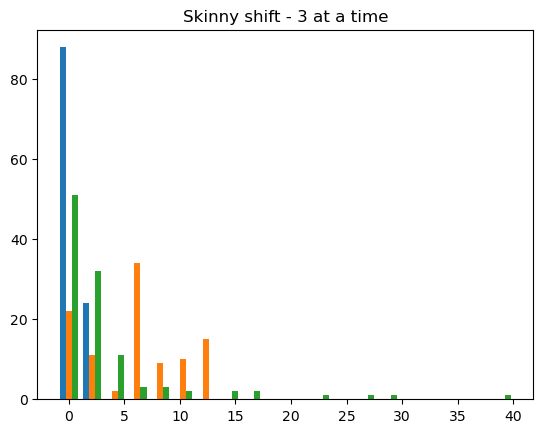

In [ ]:
common_params = dict(bins=20, range=[-1, 40])
plt.title('Skinny shift - 3 at a time')
plt.hist((a, b, c), **common_params)

(array([91.,  8.,  4.,  3.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ -1.  ,   4.05,   9.1 ,  14.15,  19.2 ,  24.25,  29.3 ,  34.35,
         39.4 ,  44.45,  49.5 ,  54.55,  59.6 ,  64.65,  69.7 ,  74.75,
         79.8 ,  84.85,  89.9 ,  94.95, 100.  ]),
 [<matplotlib.patches.Polygon at 0x24d0b1e51f0>])

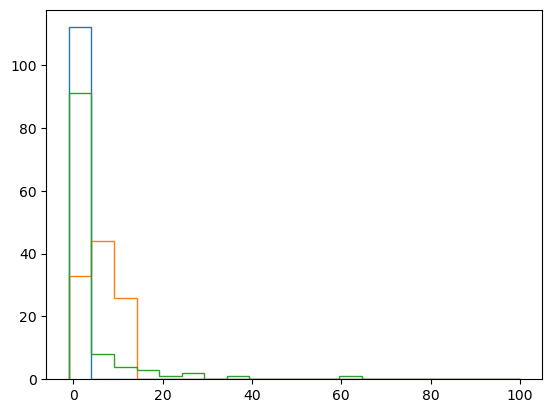

In [ ]:
plt.hist(a, **common_params)
plt.hist(b, **common_params)
plt.hist(c, **common_params)

In [ ]:
sns.histplot(data=df, x='missing elements', hue="Mine_Stage", multiple="stack", bins = 45)


(array([102.000000, 4.000000, 3.000000, 1.000000, 0.000000, 1.000000,
        0.000000, 0.000000, 0.000000, 1.000000]),
 array([0.000000, 10.550000, 21.100000, 31.650000, 42.200000, 52.750000,
        63.300000, 73.850000, 84.400000, 94.950000, 105.500000]),
 <BarContainer object of 10 artists>)

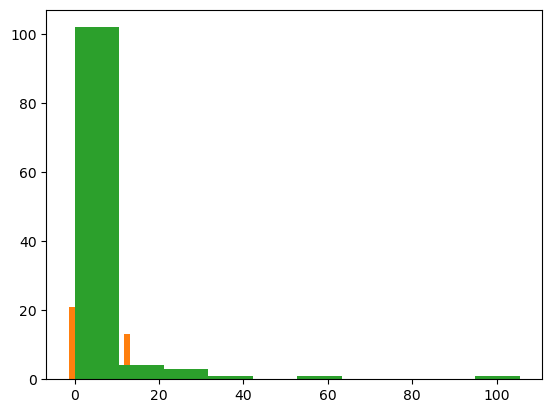

In [ ]:
import matplotlib.pyplot as plt
plt.hist(f_mean, bins=10)
plt.hist(fw_mean_original, bins=10)
plt.hist(val_y, bins=10)

In [ ]:
np.max(f_mean), np.max(fw_mean_original), np.max(val_y)

(2.827188029208113, 13.222190285748855, 105.5)

In [ ]:
np.mean(f_mean), np.mean(fw_mean_original), np.mean(val_y)

(0.667671150181275, 5.320475449775332, 4.698083928571429)

In [ ]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

print(np.vstack((f_mean.reshape(-1), fw_mean_original.reshape(-1), np.array(val_y).reshape(-1))).T)


[[0.372301 -1.367498 0.000000]
 [0.035242 -0.978207 0.984000]
 [0.037350 -0.992599 1.405000]
 [0.039556 -1.004324 1.895000]
 [0.041863 -1.013364 1.990000]
 [0.044274 -1.019698 105.500000]
 [0.046790 -1.023309 28.300000]
 [0.049415 -1.024178 6.700000]
 [0.052149 -1.022286 9.210000]
 [0.054996 -1.017615 9.710000]
 [0.057958 -1.010149 6.250000]
 [0.061035 -0.999870 6.870000]
 [0.064230 -0.986761 7.550000]
 [0.126677 -0.440637 9.340000]
 [0.131778 -0.380362 0.949000]
 [0.136985 -0.317044 0.950000]
 [0.142294 -0.250678 1.100000]
 [0.147700 -0.181254 1.595000]
 [0.153199 -0.108767 2.460000]
 [0.158786 -0.033210 1.610000]
 [0.164456 0.045423 3.860000]
 [0.170203 0.127136 2.650000]
 [0.176021 0.211934 3.250000]
 [0.181903 0.299821 1.890000]
 [0.187843 0.390801 1.830000]
 [0.193833 0.484874 1.700000]
 [0.199866 0.582045 1.440000]
 [0.205934 0.682314 2.480000]
 [0.212028 0.785682 1.115000]
 [0.218141 0.892149 0.630000]
 [0.224262 1.001715 1.315000]
 [0.230384 1.114379 2.180000]
 [0.236496 1.2301

In [ ]:


fig = px.scatter_3d(val_subset, x=val_subset['EAST_mid_tf'], y=val_subset['NORTH_mid_tf'], z=val_subset['RL_mid_tf'],
              color=val_subset['Cu_pct'], color_continuous_scale='viridis')




fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=21, range=[0,2100],),
                     yaxis = dict(nticks=15, range=[0,1500],),
                     zaxis = dict(nticks=18, range=[0,1770],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.update_traces(marker_size = 4)

fig.show()

In [ ]:


fig = px.scatter_3d(val_subset, x=val_subset['EAST_mid_tf'], y=val_subset['NORTH_mid_tf'], z=val_subset['RL_mid_tf'],
              color=fw_mean_original, color_continuous_scale='viridis')




fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=21, range=[0,2100],),
                     yaxis = dict(nticks=15, range=[0,1500],),
                     zaxis = dict(nticks=18, range=[0,1770],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.update_traces(marker_size = 4)

fig.show()

In [ ]:
fw_mean_original =fw_mean_original.reshape(-1)
np.shape(fw_mean_original)

(112,)